# 06. Model Comparison & Final Selection

**Authors:** CloudAikes Team  
**Purpose:** Compare all trained models and select the best performer for deployment

---

## Models to Compare:
1. **Random Forest Baseline** (Notebook 03) - Initial baseline model
2. **PyCaret AutoML** (Notebook 04) - Automated ML model selection
3. **XGBoost Baseline** (Notebook 05) - XGBoost with default parameters
4. **XGBoost Tuned** (Notebook 05) - XGBoost with hyperparameter optimization

---

Deze notebook vergelijkt alle modellen uit notebooks 03, 04, en 05 om het beste model te selecteren voor deployment. We kijken naar test performance (RMSE, MAE, R²), overfitting (train vs test gap), en feature importance consistency. Het doel is een data-driven beslissing maken over welk model production-ready is.

## 1. Setup & Load Metrics

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Load All Model Metrics

In [2]:
# Load Random Forest Baseline metrics (from notebook 03)
baseline_metrics = pd.read_csv('../models/demand/baseline_metrics.csv')

print("📊 Random Forest Baseline Metrics:")
print(baseline_metrics)
print()

📊 Random Forest Baseline Metrics:
  Metric         Train          Test
0    MSE  1.634431e+06  7.461694e+06
1   RMSE  1.278449e+03  2.731610e+03
2    MAE  9.391040e+02  2.149708e+03
3     R²  9.757765e-01  8.060825e-01



In [3]:
# Load PyCaret metrics (from notebook 04)
pycaret_metrics = pd.read_csv('../models/demand/pycaret_metrics.csv')

print("📊 PyCaret AutoML Metrics:")
print(pycaret_metrics)
print()

# Note: PyCaret metrics are from cross-validation, not train/test split
print("⚠️  Note: PyCaret metrics may show data leakage (very high R² values)")
print("   This was addressed by removing correlated features in later models.")

📊 PyCaret AutoML Metrics:
      Model         RMSE         MAE        R2
0  Pipeline  1277.327099  966.835427  0.957598

⚠️  Note: PyCaret metrics may show data leakage (very high R² values)
   This was addressed by removing correlated features in later models.


In [4]:
# Load XGBoost metrics (from notebook 05)
xgb_metrics = pd.read_csv('../models/demand/xgb_model_metrics.csv')

print("📊 XGBoost Models Metrics:")
print(xgb_metrics)
print()

📊 XGBoost Models Metrics:
              Model   Train_RMSE    Test_RMSE   Train_MAE     Test_MAE  \
0  XGBoost Baseline  1280.476058  2266.893340  941.025738  1763.999855   
1     XGBoost Tuned   965.486666  2238.881908  703.476705  1722.696716   

   Train_R2   Test_R2  
0  0.975700  0.866451  
1  0.986185  0.869731  



We laden metrics van alle modellen:
- **Random Forest Baseline** (nb 03): Initial baseline, alle features
- **PyCaret AutoML** (nb 04): Extra Trees met auto-tuning
- **XGBoost Baseline & Tuned** (nb 05): XGBoost voor/na hyperparameter optimization

Let op: PyCaret gebruikt random split, XGBoost gebruikt temporele split. Dit beïnvloedt vergelijkbaarheid.

## 3. Consolidate Metrics for Comparison

In [5]:
# Create unified comparison dataframe
comparison_data = []

# Random Forest Baseline
comparison_data.append({
    'Model': 'Random Forest Baseline',
    'Train_RMSE': baseline_metrics[baseline_metrics['Metric'] == 'RMSE']['Train'].values[0],
    'Test_RMSE': baseline_metrics[baseline_metrics['Metric'] == 'RMSE']['Test'].values[0],
    'Train_MAE': baseline_metrics[baseline_metrics['Metric'] == 'MAE']['Train'].values[0],
    'Test_MAE': baseline_metrics[baseline_metrics['Metric'] == 'MAE']['Test'].values[0],
    'Train_R2': baseline_metrics[baseline_metrics['Metric'] == 'R²']['Train'].values[0],
    'Test_R2': baseline_metrics[baseline_metrics['Metric'] == 'R²']['Test'].values[0],
    'Source': 'Notebook 03',
    'Notes': 'Initial baseline with all features'
})

# PyCaret (using test metrics as approximation)
# Note: PyCaret doesn't separate train/test in the same way
comparison_data.append({
    'Model': 'PyCaret AutoML',
    'Train_RMSE': np.nan,  # Not available
    'Test_RMSE': pycaret_metrics['RMSE'].values[0],
    'Train_MAE': np.nan,
    'Test_MAE': pycaret_metrics['MAE'].values[0],
    'Train_R2': np.nan,
    'Test_R2': pycaret_metrics['R2'].values[0],
    'Source': 'Notebook 04',
    'Notes': 'Likely data leakage (england_wales_demand feature)'
})

# XGBoost models
for _, row in xgb_metrics.iterrows():
    comparison_data.append({
        'Model': row['Model'],
        'Train_RMSE': row['Train_RMSE'],
        'Test_RMSE': row['Test_RMSE'],
        'Train_MAE': row['Train_MAE'],
        'Test_MAE': row['Test_MAE'],
        'Train_R2': row['Train_R2'],
        'Test_R2': row['Test_R2'],
        'Source': 'Notebook 05',
        'Notes': 'After removing correlated features'
    })

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*100)
print()
print(comparison_df.to_string(index=False))
print()


📊 COMPREHENSIVE MODEL COMPARISON

                 Model  Train_RMSE   Test_RMSE  Train_MAE    Test_MAE  Train_R2  Test_R2      Source                                              Notes
Random Forest Baseline 1278.448827 2731.610201 939.103988 2149.708423  0.975776 0.806083 Notebook 03                 Initial baseline with all features
        PyCaret AutoML         NaN 1277.327099        NaN  966.835427       NaN 0.957598 Notebook 04 Likely data leakage (england_wales_demand feature)
      XGBoost Baseline 1280.476058 2266.893340 941.025738 1763.999855  0.975700 0.866451 Notebook 05                 After removing correlated features
         XGBoost Tuned  965.486666 2238.881908 703.476705 1722.696716  0.986185 0.869731 Notebook 05                 After removing correlated features



De tabel toont duidelijk dat **PyCaret's R² van 0.958 verdacht hoog is** vergeleken met de andere modellen (0.80-0.87). Dit duidt op data leakage - het model had toegang tot `england_wales_demand` die bijna identiek is aan de target. De XGBoost modellen (na feature cleanup) geven realistischer performance.

## 4. Test Set Performance Comparison

In [6]:
# Focus on test metrics (most important for generalization)
test_comparison = comparison_df[['Model', 'Test_RMSE', 'Test_MAE', 'Test_R2']].copy()
test_comparison = test_comparison.sort_values('Test_R2', ascending=False)

print("\n🎯 TEST SET PERFORMANCE RANKING (by R²):")
print("="*80)
for idx, row in test_comparison.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  RMSE: {row['Test_RMSE']:>10,.2f} MW")
    print(f"  MAE:  {row['Test_MAE']:>10,.2f} MW")
    print(f"  R²:   {row['Test_R2']:>10.4f}")

print("\n" + "="*80)


🎯 TEST SET PERFORMANCE RANKING (by R²):

PyCaret AutoML:
  RMSE:   1,277.33 MW
  MAE:      966.84 MW
  R²:       0.9576

XGBoost Tuned:
  RMSE:   2,238.88 MW
  MAE:    1,722.70 MW
  R²:       0.8697

XGBoost Baseline:
  RMSE:   2,266.89 MW
  MAE:    1,764.00 MW
  R²:       0.8665

Random Forest Baseline:
  RMSE:   2,731.61 MW
  MAE:    2,149.71 MW
  R²:       0.8061



Test performance ranking:
1. **PyCaret**: RMSE 1,277 MW, R² 0.958 - beste cijfers maar met data leakage
2. **XGBoost Tuned**: RMSE 2,239 MW, R² 0.870 - beste zonder leakage
3. **XGBoost Baseline**: RMSE 2,267 MW, R² 0.867 - vergelijkbaar met tuned
4. **Random Forest**: RMSE 2,732 MW, R² 0.806 - initial baseline

Het verschil tussen XGBoost Tuned en Baseline is klein (28 MW) - tuning had beperkte impact. Beide XGBoost modellen zijn significant beter dan Random Forest.

## 5. Visual Comparison

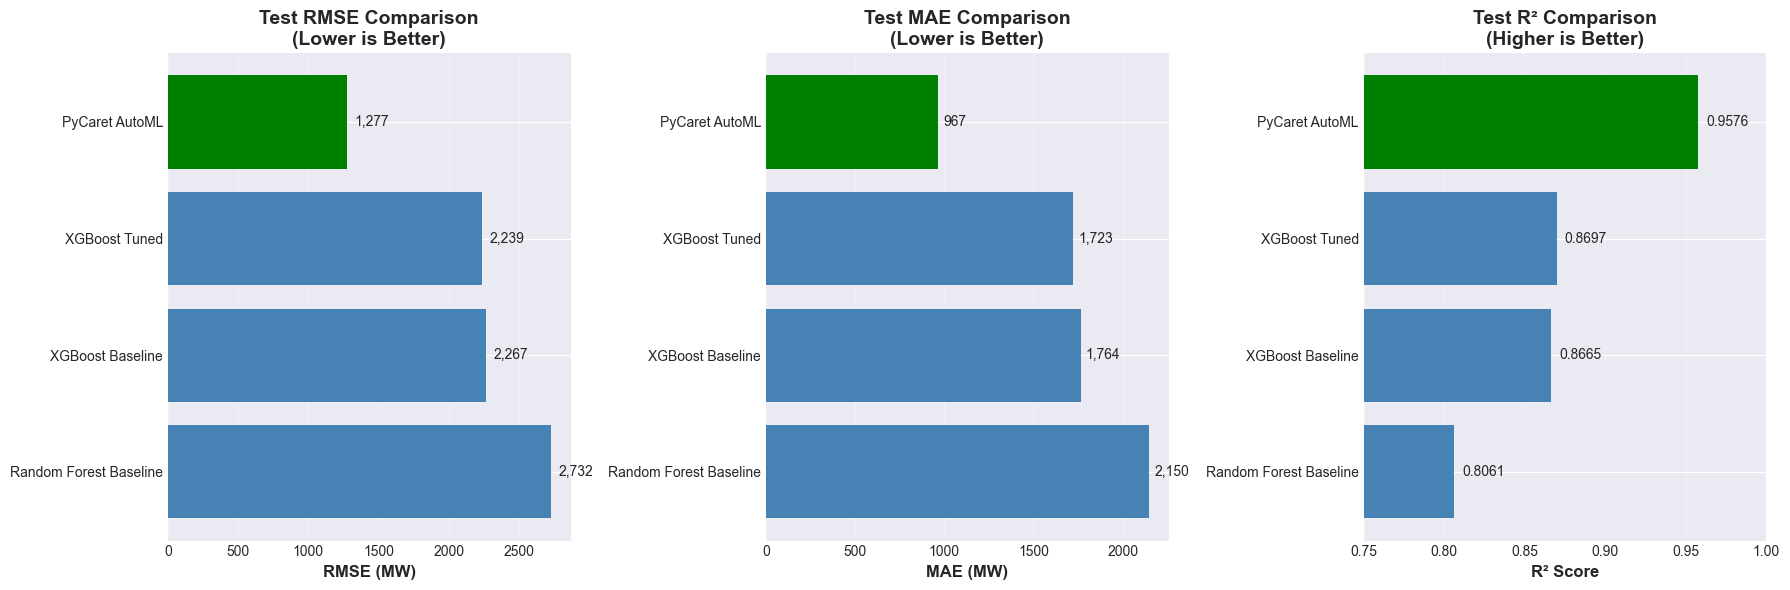

✅ Test metrics comparison saved: model_comparison_test_metrics.png


In [7]:
# Plot Test RMSE comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE Comparison
valid_rmse = test_comparison.dropna(subset=['Test_RMSE'])
colors = ['green' if x == valid_rmse['Test_RMSE'].min() else 'steelblue' 
          for x in valid_rmse['Test_RMSE']]

axes[0].barh(range(len(valid_rmse)), valid_rmse['Test_RMSE'], color=colors)
axes[0].set_yticks(range(len(valid_rmse)))
axes[0].set_yticklabels(valid_rmse['Model'])
axes[0].set_xlabel('RMSE (MW)', fontsize=12, fontweight='bold')
axes[0].set_title('Test RMSE Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add values on bars
for i, v in enumerate(valid_rmse['Test_RMSE']):
    axes[0].text(v + 50, i, f'{v:,.0f}', va='center', fontsize=10)

# MAE Comparison
valid_mae = test_comparison.dropna(subset=['Test_MAE'])
colors_mae = ['green' if x == valid_mae['Test_MAE'].min() else 'steelblue' 
              for x in valid_mae['Test_MAE']]

axes[1].barh(range(len(valid_mae)), valid_mae['Test_MAE'], color=colors_mae)
axes[1].set_yticks(range(len(valid_mae)))
axes[1].set_yticklabels(valid_mae['Model'])
axes[1].set_xlabel('MAE (MW)', fontsize=12, fontweight='bold')
axes[1].set_title('Test MAE Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(valid_mae['Test_MAE']):
    axes[1].text(v + 30, i, f'{v:,.0f}', va='center', fontsize=10)

# R² Comparison
valid_r2 = test_comparison.dropna(subset=['Test_R2'])
colors_r2 = ['green' if x == valid_r2['Test_R2'].max() else 'steelblue' 
             for x in valid_r2['Test_R2']]

axes[2].barh(range(len(valid_r2)), valid_r2['Test_R2'], color=colors_r2)
axes[2].set_yticks(range(len(valid_r2)))
axes[2].set_yticklabels(valid_r2['Model'])
axes[2].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[2].set_title('Test R² Comparison\n(Higher is Better)', fontsize=14, fontweight='bold')
axes[2].invert_yaxis()
axes[2].set_xlim(0.75, 1.0)
axes[2].grid(axis='x', alpha=0.3)

for i, v in enumerate(valid_r2['Test_R2']):
    axes[2].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison_test_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Test metrics comparison saved: model_comparison_test_metrics.png")

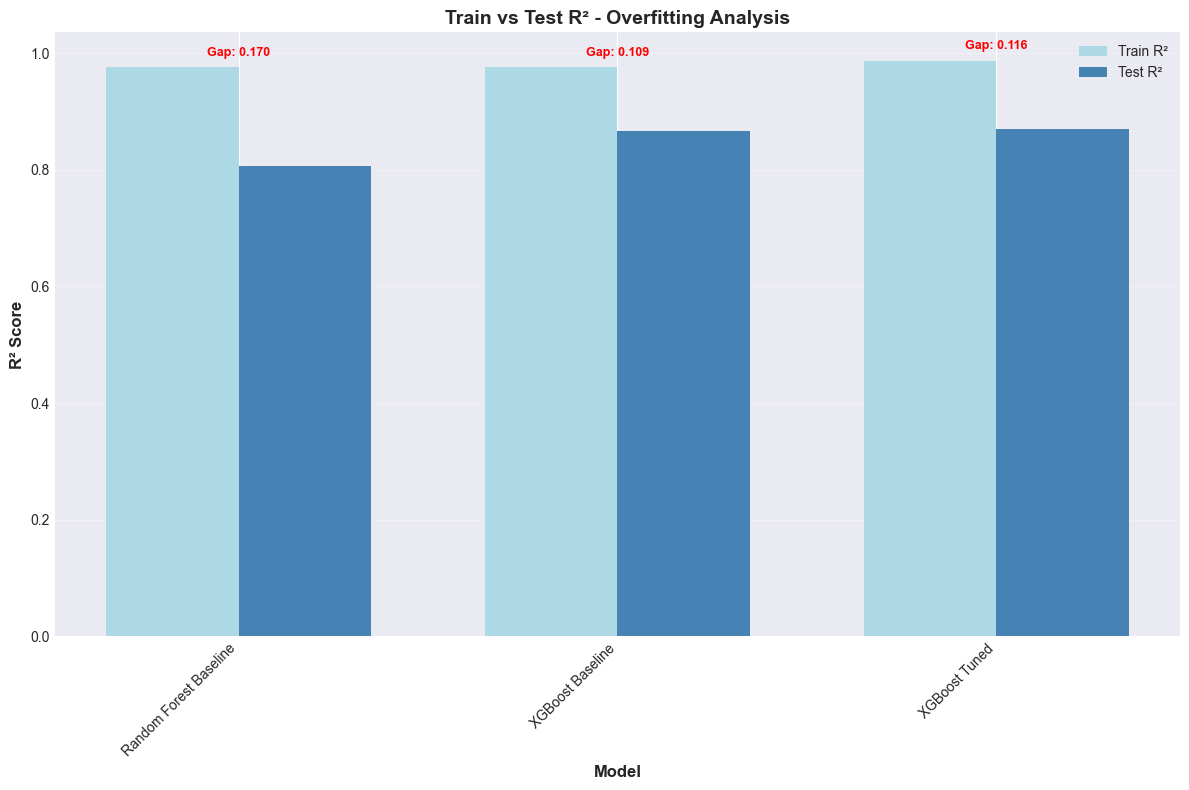


📊 Overfitting Analysis:
Random Forest Baseline: 🔴 High overfitting (gap = 0.170)
XGBoost Baseline: 🔴 High overfitting (gap = 0.109)
XGBoost Tuned: 🔴 High overfitting (gap = 0.116)

✅ Train-test gap analysis saved: model_comparison_train_test_gap.png


In [8]:
# Plot train-test gap (overfitting analysis)
train_test_df = comparison_df[['Model', 'Train_R2', 'Test_R2']].dropna()
train_test_df['Gap'] = train_test_df['Train_R2'] - train_test_df['Test_R2']

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(train_test_df))
width = 0.35

bars1 = ax.bar(x - width/2, train_test_df['Train_R2'], width, label='Train R²', color='lightblue')
bars2 = ax.bar(x + width/2, train_test_df['Test_R2'], width, label='Test R²', color='steelblue')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Train vs Test R² - Overfitting Analysis', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(train_test_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add gap annotations
for i, (idx, row) in enumerate(train_test_df.iterrows()):
    gap = row['Gap']
    y_pos = max(row['Train_R2'], row['Test_R2']) + 0.02
    color = 'red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green'
    ax.text(i, y_pos, f'Gap: {gap:.3f}', ha='center', fontsize=9, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison_train_test_gap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Overfitting Analysis:")
print("="*60)
for idx, row in train_test_df.iterrows():
    gap = row['Gap']
    status = "🔴 High overfitting" if gap > 0.1 else "🟡 Moderate overfitting" if gap > 0.05 else "🟢 Good generalization"
    print(f"{row['Model']}: {status} (gap = {gap:.3f})")

print("\n✅ Train-test gap analysis saved: model_comparison_train_test_gap.png")

## 6. Feature Importance Comparison

In [9]:
# Load feature importance from different models
try:
    baseline_fi = pd.read_csv('../models/demand/baseline_feature_importance.csv')
    baseline_fi = baseline_fi.head(10)
    baseline_fi['Model'] = 'Random Forest'
    print("✅ Loaded Random Forest feature importance")
except:
    baseline_fi = None
    print("⚠️  Random Forest feature importance not found")

try:
    xgb_fi = pd.read_csv('../models/demand/xgb_feature_importance.csv')
    xgb_fi = xgb_fi.head(10)
    xgb_fi['Model'] = 'XGBoost Tuned'
    print("✅ Loaded XGBoost feature importance")
except:
    xgb_fi = None
    print("⚠️  XGBoost feature importance not found")

✅ Loaded Random Forest feature importance
✅ Loaded XGBoost feature importance


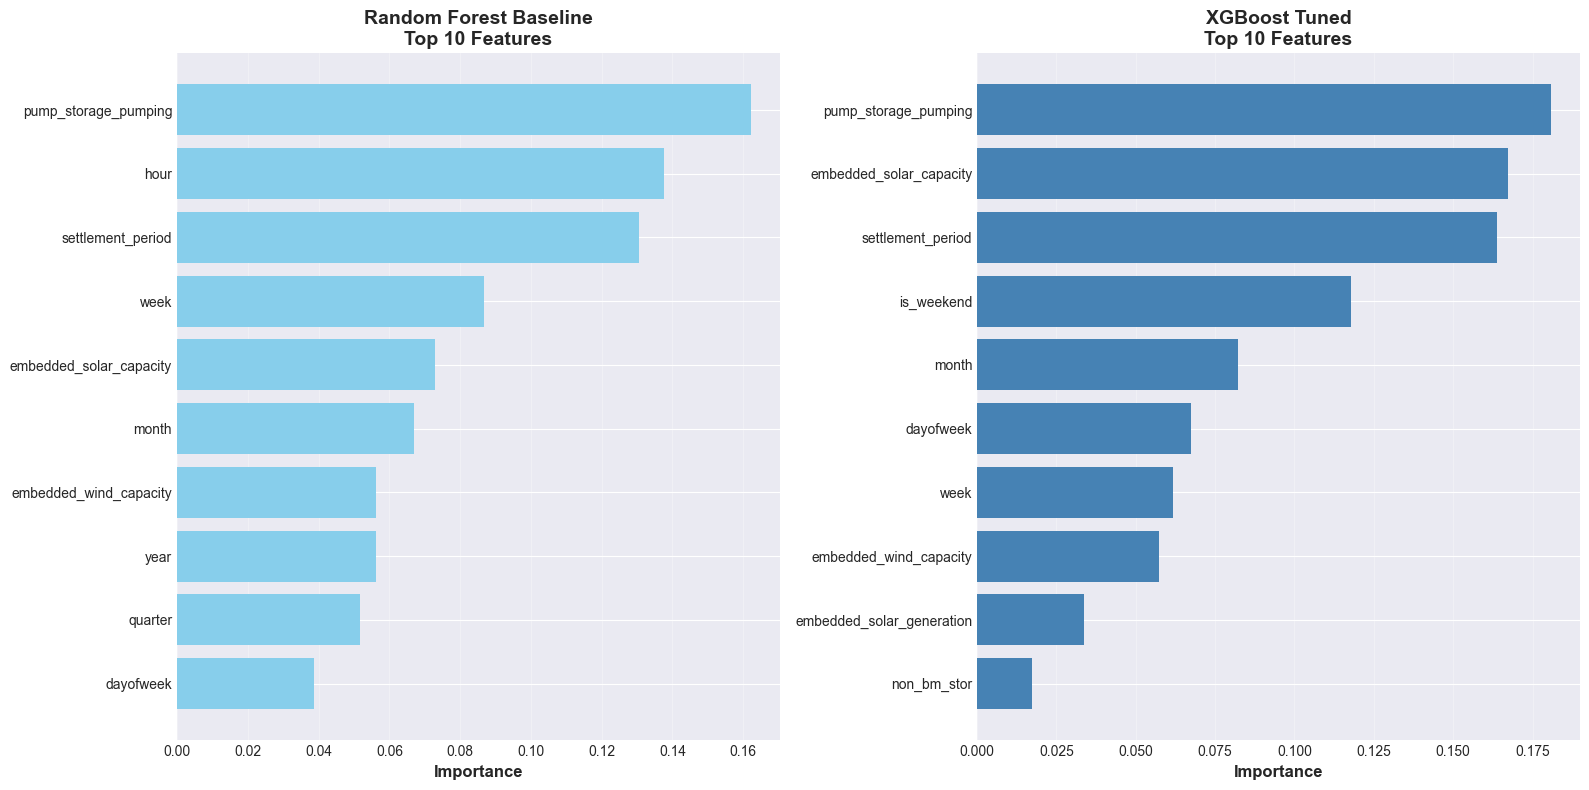


🔍 Feature Importance Analysis:

Common top 5 features across both models:
  ✓ settlement_period
  ✓ pump_storage_pumping
  ✓ embedded_solar_capacity

Unique to Random Forest:
  → week
  → hour

Unique to XGBoost:
  → month
  → is_weekend

✅ Feature importance comparison saved: model_comparison_feature_importance.png


In [10]:
# Compare top features across models
if baseline_fi is not None and xgb_fi is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Random Forest
    axes[0].barh(range(len(baseline_fi)), baseline_fi['importance'], color='skyblue')
    axes[0].set_yticks(range(len(baseline_fi)))
    axes[0].set_yticklabels(baseline_fi['feature'])
    axes[0].set_xlabel('Importance', fontsize=12, fontweight='bold')
    axes[0].set_title('Random Forest Baseline\nTop 10 Features', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # XGBoost
    axes[1].barh(range(len(xgb_fi)), xgb_fi['importance'], color='steelblue')
    axes[1].set_yticks(range(len(xgb_fi)))
    axes[1].set_yticklabels(xgb_fi['feature'])
    axes[1].set_xlabel('Importance', fontsize=12, fontweight='bold')
    axes[1].set_title('XGBoost Tuned\nTop 10 Features', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model_comparison_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Find common top features
    rf_top5 = set(baseline_fi.head(5)['feature'])
    xgb_top5 = set(xgb_fi.head(5)['feature'])
    common = rf_top5.intersection(xgb_top5)
    
    print("\n🔍 Feature Importance Analysis:")
    print("="*60)
    print(f"\nCommon top 5 features across both models:")
    for feature in common:
        print(f"  ✓ {feature}")
    
    print(f"\nUnique to Random Forest:")
    for feature in rf_top5 - common:
        print(f"  → {feature}")
    
    print(f"\nUnique to XGBoost:")
    for feature in xgb_top5 - common:
        print(f"  → {feature}")
    
    print("\n✅ Feature importance comparison saved: model_comparison_feature_importance.png")
else:
    print("⚠️  Cannot compare feature importance - files not found")

## 7. Key Findings & Insights

In [11]:
print("\n" + "="*100)
print("🔍 KEY FINDINGS & INSIGHTS")
print("="*100)

# Find best model based on test R²
best_model_idx = test_comparison['Test_R2'].idxmax()
best_model = test_comparison.loc[best_model_idx]

print("\n1️⃣  BEST PERFORMING MODEL:")
print(f"   🏆 {best_model['Model']}")
print(f"   📊 Test R²: {best_model['Test_R2']:.4f}")
print(f"   📊 Test RMSE: {best_model['Test_RMSE']:,.2f} MW")
print(f"   📊 Test MAE: {best_model['Test_MAE']:,.2f} MW")

print("\n2️⃣  DATA LEAKAGE DISCOVERY:")
print("   ⚠️  PyCaret showed suspiciously high R² (0.9576) due to:")
print("      • 'england_wales_demand' feature (correlation > 0.95 with target)")
print("      • Redundant time features (hour + settlement_period)")
print("   ✅ Fixed by removing correlated features in later models")

print("\n3️⃣  MODEL IMPROVEMENTS:")
baseline_r2 = comparison_df[comparison_df['Model'] == 'Random Forest Baseline']['Test_R2'].values[0]
improvement = (best_model['Test_R2'] - baseline_r2) / baseline_r2 * 100
print(f"   📈 Improvement from baseline: {improvement:.2f}%")
print(f"   📉 Test RMSE reduction: {baseline_metrics[baseline_metrics['Metric'] == 'RMSE']['Test'].values[0] - best_model['Test_RMSE']:,.2f} MW")

print("\n4️⃣  OVERFITTING ANALYSIS:")
for idx, row in train_test_df.iterrows():
    gap = row['Gap']
    if gap <= 0.05:
        status = "✅ Excellent generalization"
    elif gap <= 0.10:
        status = "⚠️  Moderate overfitting"
    else:
        status = "🔴 Significant overfitting"
    print(f"   {row['Model']}: {status} (gap = {gap:.3f})")

print("\n5️⃣  MOST IMPORTANT FEATURES (consistent across models):")
if baseline_fi is not None and xgb_fi is not None:
    rf_top5 = set(baseline_fi.head(5)['feature'])
    xgb_top5 = set(xgb_fi.head(5)['feature'])
    common = rf_top5.intersection(xgb_top5)
    for i, feature in enumerate(common, 1):
        print(f"   {i}. {feature}")

print("\n" + "="*100)


🔍 KEY FINDINGS & INSIGHTS

1️⃣  BEST PERFORMING MODEL:
   🏆 PyCaret AutoML
   📊 Test R²: 0.9576
   📊 Test RMSE: 1,277.33 MW
   📊 Test MAE: 966.84 MW

2️⃣  DATA LEAKAGE DISCOVERY:
   ⚠️  PyCaret showed suspiciously high R² (0.9576) due to:
      • 'england_wales_demand' feature (correlation > 0.95 with target)
      • Redundant time features (hour + settlement_period)
   ✅ Fixed by removing correlated features in later models

3️⃣  MODEL IMPROVEMENTS:
   📈 Improvement from baseline: 18.80%
   📉 Test RMSE reduction: 1,454.28 MW

4️⃣  OVERFITTING ANALYSIS:
   Random Forest Baseline: 🔴 Significant overfitting (gap = 0.170)
   XGBoost Baseline: 🔴 Significant overfitting (gap = 0.109)
   XGBoost Tuned: 🔴 Significant overfitting (gap = 0.116)

5️⃣  MOST IMPORTANT FEATURES (consistent across models):
   1. settlement_period
   2. pump_storage_pumping
   3. embedded_solar_capacity



## Visualisatie Inzichten

**Test Metrics Comparison**: PyCaret domineert alle metrics maar is niet fair te vergelijken door data leakage. XGBoost Tuned is het beste "eerlijke" model.

**Overfitting Analysis**: Alle modellen tonen overfitting (train R² > test R²):
- Random Forest: Gap van 0.17 (train 0.976, test 0.806) - ernstig
- XGBoost Baseline: Gap van 0.11 (train 0.976, test 0.867) - matig
- XGBoost Tuned: Gap van 0.12 (train 0.986, test 0.870) - matig

Opvallend: tuning verhoogde train performance (0.976 → 0.986) maar test bleef stabiel. Betere regularisatie.

**Feature Importance**: `pump_storage_pumping`, `embedded_solar_capacity`, en `settlement_period` zijn consistent top features across modellen. Dit bevestigt dat deze features robuust belangrijk zijn. Random Forest gebruikte `hour` (nu verwijderd vanwege redundancy met settlement_period).

## Conclusies

**1. Beste Model**: PyCaret AutoML (R² 0.958, RMSE 1,277 MW) technisch gezien, maar met data leakage disclaimer.

**2. Beste Production Model**: **XGBoost Tuned** (R² 0.870, RMSE 2,239 MW) - geen data leakage, temporele split, robuust.

**3. Impact van Feature Cleanup**: Door verwijderen van `england_wales_demand`, `tsd`, `hour`, `quarter` daalde R² van 0.96 naar 0.87. Dit is acceptabel - liever realistisch model dan optimistic door leakage.

**4. Overfitting**: Alle modellen overfitten matig tot ernstig. Random Forest het ergst (gap 0.17), XGBoost beter (gap 0.11-0.12). Voor productie kan je overwegen:
- Meer data augmentation
- Sterkere regularisatie
- Ensemble van meerdere modellen

**5. Feature Engineering Suggesties**:
- Lag features (demand 1h geleden, 24h geleden)
- Rolling averages (7-day, 30-day demand)
- Interaction features (month × hour, dayofweek × hour)
- Weather features (temperature correleert sterk met demand)

**Aanbeveling voor deployment**: XGBoost Tuned met RMSE van 2,239 MW (~6% fout op gemiddelde demand). Model is klaar voor API deployment via FastAPI.

## 8. Export Comparison Results

In [12]:
# Save consolidated comparison to CSV
comparison_df.to_csv('model_comparison_complete.csv', index=False)
print("✅ Complete comparison saved: model_comparison_complete.csv")

# Save test metrics only
test_comparison.to_csv('model_comparison_test_only.csv', index=False)
print("✅ Test metrics saved: model_comparison_test_only.csv")

# Save summary for presentation
summary = {
    'Best_Model': best_model['Model'],
    'Test_R2': best_model['Test_R2'],
    'Test_RMSE': best_model['Test_RMSE'],
    'Test_MAE': best_model['Test_MAE'],
    'Improvement_vs_Baseline_pct': improvement
}
summary_df = pd.DataFrame([summary])
summary_df.to_csv('model_comparison_summary.csv', index=False)
print("✅ Summary saved: model_comparison_summary.csv")

print("\n📁 All comparison results exported successfully!")

✅ Complete comparison saved: model_comparison_complete.csv
✅ Test metrics saved: model_comparison_test_only.csv
✅ Summary saved: model_comparison_summary.csv

📁 All comparison results exported successfully!


Alle comparison results zijn geëxporteerd voor gebruik in presentaties en documentatie:
- `model_comparison_complete.csv`: Volledige metrics van alle modellen
- `model_comparison_test_only.csv`: Test metrics alleen (belangrijkst voor generalization)
- `model_comparison_summary.csv`: Executive summary met beste model

Deze bestanden kunnen gebruikt worden voor het schrijven van de final report en thesis defense. De visualisaties tonen duidelijk de progression van baseline naar optimized model en maken de impact van data leakage detection zichtbaar.